In [4]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import powerlaw

In [1]:
from IPython.core.display import HTML
HTML("./custom.css")

<h1>How big are your banks?</h1>
<h2>The ones in the U.S. are <em>pretty</em> big!</h2>

<h3>Dr. David R. Pugh</h3>

<img src="./assets/img/pydata-logo-amsterdam-2016.png" alt="PyData Amsterdam">
<h4>Amsterdam, The Netherlands, 12-13 March 2016</h4>

<img src="../../assets/img/INET_Brand_Final-01.png" alt="Institute for New Economic Thinking" width=500>

<h1> Motivation </h1>

Generally accepted wisdom that many banks in the U.S. (and elsewhere) have become "too big too fail." Is this true? Have banks somehow become excessively large relative to (recent) historical experience? How about relative to some null model of bank size?

<strong>Primary motivation is to establish "facts on the ground" concerning the distribution of U.S. banks and how it has evolved (or not!) over time.</strong>

Benefits of banking sector concentration, such as increased profitability, economies of scale, and increased diversification accrue primarily to individual banks (and their shareholders). 

Costs of increased banking sector concentration, meanwhile, are largely social. These might include increased propensity to take risks due to moral hazard/adverse selection issues created by explicit deposit insurance arrangements as well as implicit bail-out arrangements for banks deemed "too big to fail," decreased competitiveness in the banking sector, etc.  

Characterizing the  behavior of the upper tail of the size distribution of banks is an important prerequisite to quantitatively assessing the potential costs and benefits from continued concentration of the U.S. banking sector.

<h2>I have a hypothesis!</h2>

In general, a power law...
$$ p(x; x_{min}, \alpha) = \left(\frac{\alpha - 1}{x_{min}}\right)\left(\frac{x_{min}}{x}\right)^{\alpha} $$

...in particular, Zipf's Law (i.e., power law with $\alpha = 2$)

Why? Strong empirical evidence from <a href="http://www.uvm.edu/~pdodds/files/papers/others/2001/axtell2001a.pdf">Axtell (<em>Science</em>, 2001)</a> and others that distribution of firm sizes is well decribed by Zipf's Law. So Zipf's Law seems a reasonable starting point...

<h1> Data </h1>

<h3> Statistics on Depository Institutions </h3>

<p>Data used in this study are taken from the <a href="http://www2.fdic.gov/sdi/index.asp">Statistics on Depository Institutions (SDI)</a> database maintained by the U.S. Federal Deposit Insurance Corporation (FDIC).<p>

FDIC makes it hard to access the SDI data in bulk...so I wrote a little Python scripts to crawl the FDIC's website and download the data, and format it into a Pandas Panel object.

SDI data set contains aggregate demographic and financial information about the U.S. banking sector, as well detailed <em>quarterly</em> data on individual bank (or bank holding company) balance sheets, income statements, performance ratios, etc., dating back to 1992.

<p>I look at six separate measures of bank size:</p>
<ul>
  <li><strong>Total assets (`asset`):</strong> The sum of all assets owned by the institution including cash, loans, securities, bank premises and other assets. This total does not include off-balance-sheet accounts.</li>
  <li><strong>Total loans (`lnlsnet`):</strong> Total loans and lease financing receivables minus unearned income and loan loss allowances.</li>
  <li><strong>Total liabilities (`liab`):</strong> Deposits and other borrowings, subordinated notes and debentures, limited-life preferred stock and related surplus, trading account liabilities and mortgage indebtedness.</li>
  <li><strong>Total deposits (`dep`):</strong> The sum of all deposits including demand deposits, money market deposits, other savings deposits, time deposits and deposits in foreign offices.</li>
  <li><strong>Total equity (`toteq`):</strong> Total equity capital on a consolidated basis.</li>
  <li><strong>Total employees (`numemp`):</strong> The number of full-time employees on the payroll of the bank and its subsidiaries at the end of the quarter.</li>
</ul>

Interested in the <em>shape</em> of the size distribution: I deflate and then re-scale each measure of bank size by dividing by banking sector totals relative to some base year, $T$...

$$  S_{i,t}^{norm} = \left(\frac{\sum_{j}S_{i, T}^{raw}}{\sum_{j}S_{j,t}^{raw}}\right)S_{i,t}^{raw}. $$

In case anyone asks...
<ul>
  <li>$S_{i,t}^{raw}$ denotes the raw size of bank $i$ in year $t$ based on one of the six size measures detailed above.</li>
  <li>$\sum_{j}S_{j,t}^{raw}$ is the banking sector total of some size measure in year $t$.</li>
  <li>$\sum_{j}S_{j,T}^{raw}$ is the banking sector total of the same size measure in the base year.</li>
</ul>

<h2> Exploratory data analysis </h2>

In [5]:
# load the raw FDIC SDI data...
fdic_sdi_panel = pd.read_pickle('./FDIC_SDI_panel_nominal.pkl')

In [6]:
print(fdic_sdi_panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 6 (items) x 16523 (major_axis) x 92 (minor_axis)
Items axis: numemp to eqtot
Major_axis axis: 8 to 91393
Minor_axis axis: 1992-12-31 00:00:00 to 2015-09-30 00:00:00


In [357]:
def normalize_size_measure(size_measure, base_date='2015-09-30'):
    """Normalize the raw data for some size measure."""
    base_date_totals = fdic_sdi_panel.minor_xs(base_date)[size_measure].sum()
    scaling_factor = base_date_totals / fdic_sdi_panel.asset.sum()
    return scaling_factor * fdic_sdi_panel[size_measure]


def nlargest_banks_share(item, n):
    """Compute the market share of a data item for the n largest banks."""
    data = fdic_sdi_panel[item]
    dates = fdic_sdi_panel.minor_axis
    nlargest_banks = pd.concat([data.nlargest(n, date)[date] for date in dates], axis=1)
    return nlargest_banks.sum() / fdic_sdi_panel[item].sum()


def plot_nlargest_bank_share(n, figsize=(10, 8)):
    """Plot the market share of the n largest banks for each size measure."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for size_measure in fdic_sdi_panel.items:
        data = nlargest_banks_share(size_measure, n)
        data.plot(ax=ax, label=size_measure)
    
    # format the axis
    ax.legend(loc=0, frameon=False)
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylabel('Market share', fontsize=20)
    
    return fig


def plot_number_regulated_banks(figsize=(10, 8)):
    """Plot a times series of the number of FDIC reguated banks."""
    # create the figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data = fdic_sdi_panel.asset.count()
    data.plot(ax=ax)

    # apply formatting
    ax.set_xlabel('Report date', fontsize=20)
    ax.set_ylim(0, 15000)
    ax.set_ylabel('Number of FDIC regulates banks', fontsize=20)
    ax.set_title('Impact of Mergers and Acquisitions', fontsize=25)
    
    return fig

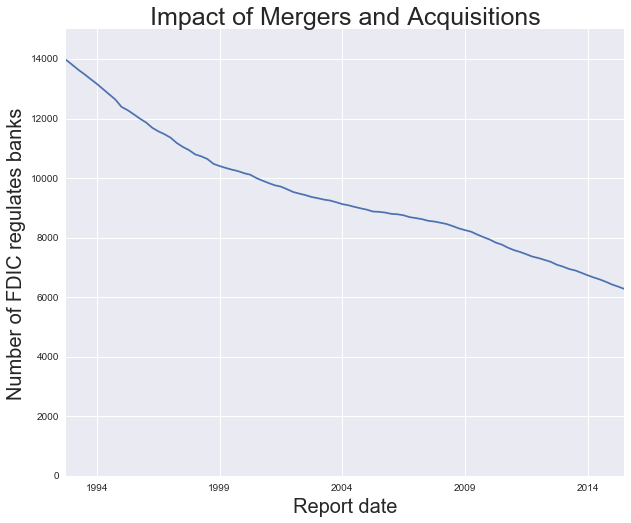

In [356]:
fig = plot_number_regulated_banks()
fig.savefig('./assets/img/number-fdic-regulated-banks.jpg')

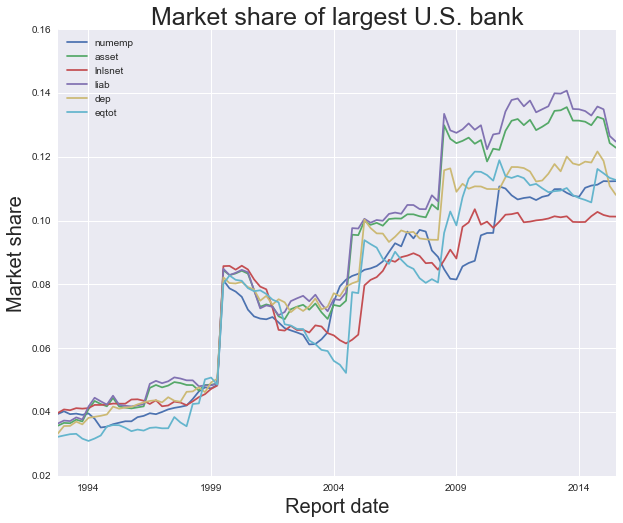

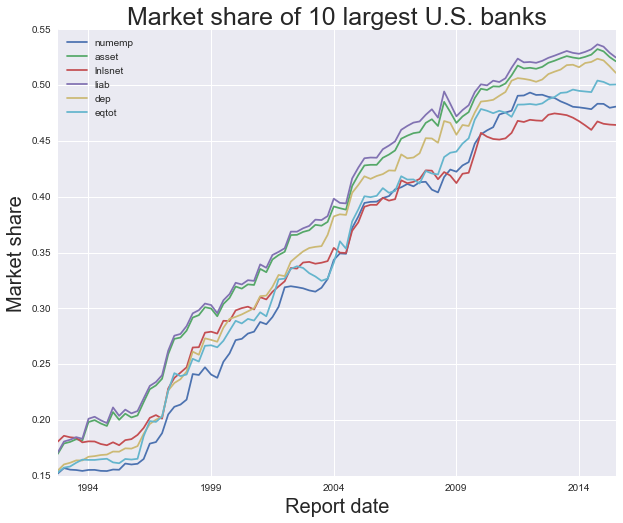

In [352]:
fig = plot_nlargest_bank_share(1)
fig.axes[0].set_title("Market share of largest U.S. bank", fontsize=25)
fig.savefig('./assets/img/largest-bank-market-share.jpg')

fig = plot_nlargest_bank_share(10)
fig.axes[0].set_title("Market share of 10 largest U.S. banks", fontsize=25)
fig.savefig('./assets/img/nlargest-banks-market-share.jpg')

<h2>Significant agglomeration within the U.S. banking sector...</h2>

<img src="./assets/img/number-fdic-regulated-banks.jpg" alt="Effect of M&A" width=1000>

<ul>
  <li>Q1 1992: $\approx$ 14,000 banks in the data; largest bank (Citibank), controlled $\approx$ 4% of all U.S. banking assets.</li>
  <li>Q3 2015, $\approx$ 6,000 banks remain; largest bank (now JP Morgan-Chase), controlled $\approx$ 13% of all U.S. banking assets.</li>
  <li>"Jumps" in the share of assets and liabilities controlled by the largest U.S. bank all occurred because of mergers between large banks:
    <ul>
      <li>1999: Nations Bank (largest U.S. bank in 1999), merged with Bank of America.</li> 
      <li>2004: JPMorgan-Chase (the largest bank in 2003), purchased Bank One (6th largest bank).</li>
      <li>2008: JPMorgan-Chase acquired both Bear Stearns and Washington Mutual</li>
    </ul>
  </li>
  <li>"Jumps" in market shares also hint at another important stylized fact: there seems to be no preferred scale for bank mergers and acquisitions.</li>
</ul>

Extent of agglomeration within the banking sector even more dramatic when one examines the market shares held by the ten largest U.S. banks. 

<ul>
  <li>Market share of 10 largest banks has more than doubled from less than 20% to roughly 50%.</li>
</ul>


<img src="./assets/img/largest-bank-market-share.jpg" alt="Market share of largest bank" width=1000>

<img src="./assets/img/nlargest-banks-market-share.jpg" alt="Market share of 10 largest banks" width=1000>

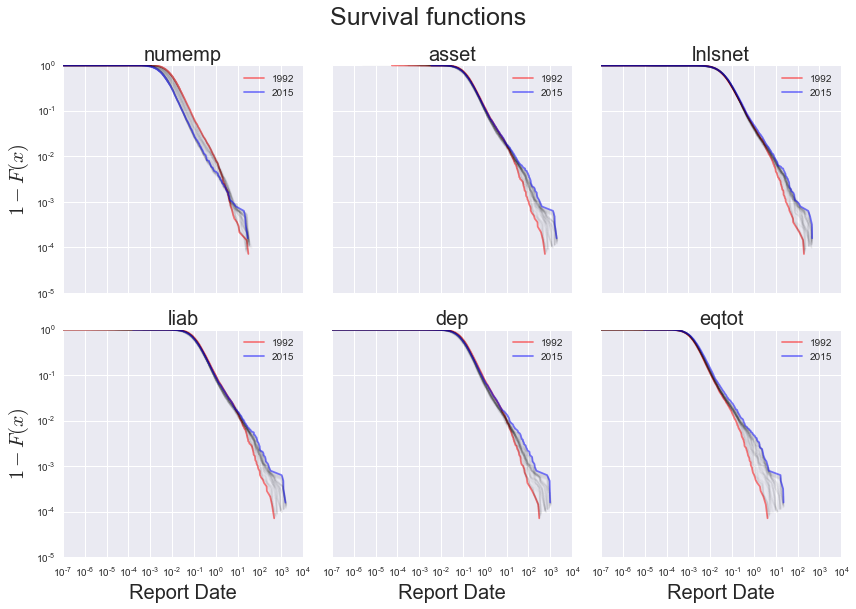

In [424]:
dates = fdic_sdi_panel.minor_axis

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
for i, size_measure in enumerate(fdic_sdi_panel.items):
    ax = axes.flatten()[i]
    
    df = normalize_size_measure(size_measure)
    
    for t, date in enumerate(fdic_sdi_panel.minor_axis):
        series = df[date].dropna()
        ecdf = sm.distributions.ECDF(series)
        if t == 0:
            ax.plot(ecdf.x[1:], 1 - ecdf.y[:-1], alpha=0.5, color='r', label="1992")
        elif t == (fdic_sdi_panel.minor_axis.size - 1):
            ax.plot(ecdf.x[1:], 1 - ecdf.y[:-1], alpha=0.5, color='b', label="2015")
        else:
            ax.plot(ecdf.x[1:], 1 - ecdf.y[:-1], alpha=0.01, color='k')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

    if i in [0, 3]:
        ax.set_ylabel(r'$1 - F(x)$', fontsize=20)
    if i in [3, 4, 5]:
        ax.set_xlabel("Report Date", fontsize=20)

    #ax.set_ylim(1.5, 2.5)
    ax.set_title(size_measure, fontsize=20)


fig.tight_layout()
fig.suptitle("Survival functions", x=0.5, y=1.05, fontsize=25)
fig.savefig('./assets/img/sf-various-size-measures.jpg', bbox_inches='tight')

<img src="./assets/img/sf-various-size-measures.jpg" alt="Survival functions for various size measures" width=1000>

<h2>Methodology</h2>

Follow the methodology advocated by <a href="http://arxiv.org/abs/0706.1062">Clauset et al (SIAM, 2009)...</a>

<h3> Don't use OLS, use maximum likelihood!</h3>

<h3> Why not OLS? </h3>
<p>There are several issues with the above OLS based procedures (in addition to the arbitrary nature of the choice for $x_{min}$).</p>
<ul>
  <li> Estimates of the scaling exponent obtained using OLS are significantly biased even in large (i.e., $N\approx 1e5$) samples.</li>
  <li> Estimating scaling exponent via OLS based on using empirical pdf using OLS is particularly bad as the magnitude of the bias is sensitive to the technique used to estimate the pdf.</li>
  <li>Classic OLS standard errors for the scaling exponent are no longer valid as adjacent values of both empirical CDF or log-rank are highly correlated by construction and this introduces significant correlations into the disurbance term.</li>
  <li>No guarantee that the OLS estimate of the scaling exponent will, when combined with the researcher's choice of $x_{min}$, result in a valid probability distribution.</li>
  <li>Many non power law distributions that will appear to be "roughly linear" when plotted on doubly logarithmic scales. OLS estimation of scaling exponent leads to spuriously high values of $R^2$ in these cases.
</ul>

<h3> Maximum Likelihood Estimator </h3>

Assuming data $x_i,\ i=i,\dots,n$ are <em>independent</em>, then, for a given value of $x_{min}$, the maximum likelihood estimator for the scaling exponent is

$$ \hat{\alpha} = 1 +  n\left[\sum_{i=1}^{n}\mathrm{ln}\ \left(\frac{x_{i}}{x_{min}}\right)\right]^{-1}. $$

The maximum likelihood estimator is equivalent to the Hill Estimator widely used in Extreme Value statistics.

In [431]:
import collections

import numpy as np
import statsmodels as sm

class PowerLaw(object):
    
    FitResult = collections.namedtuple('FitResult', ['alpha', 'xmin', 'D', 'sample'])
        
    @classmethod
    def fit(cls, data, xmin=None):
        cleaned_data = cls._clean_data(data)
        if xmin is None:
            candidate_xmins = cleaned_data < cleaned_data.quantile(0.99)
            xmin, D = cls._find_optimal_xmin(cleaned_data, cleaned_data[candidate_xmins])
        else:
            D = cls._compute_ks_distance(cleaned_data, xmin)
        alpha_hat, sample = cls._fit_maximum_likelihood(cleaned_data, xmin)
        result = cls.FitResult(alpha_hat, xmin, D, sample)
        return result
    
    @staticmethod
    def _cdf(values, alpha, xmin):
        """Cumulative distribution function (CDF) for a Pareto distribution."""
        assert (values >= xmin).all(), "CDF is not defined for data values < xmin."
        return 1 - (xmin / values)**alpha
    
    @staticmethod
    def _clean_data(data):
        """Remove any non-positive, null, or NAN observations."""
        return data[data > 0].dropna()
    
    @staticmethod
    def _ecdf(data):
        """Empirical cumulative distribution function (ECDF) of some data values."""
        #return (values[:, np.newaxis] <= values).mean(axis=0)
        return sm.distributions.ECDF(data)
        
    @staticmethod
    def _fit_maximum_likelihood(clean_data, xmin):
        r"""Maximum likelihood estimator of the scaling exponent :math:`\alpha`."""
        sample = clean_data[clean_data >= xmin]
        n = sample.count()
        alpha_hat = 1 + n * (np.log(sample / xmin).sum())**-1
        return alpha_hat, sample
    
    @classmethod
    def _compute_ks_distance(cls, candidate_xmin, clean_data):
        """Compute the Kolmogorov-Smirnov (KS) distance."""
        alpha_hat, sample = cls._fit_maximum_likelihood(clean_data, candidate_xmin)
        ecdf = cls._ecdf(sample)
        theoretical_cdf = cls._cdf(ecdf.x[1:], alpha_hat, candidate_xmin)
        D = np.max(np.abs(ecdf.y[:-1] - theoretical_cdf))
        return D
    
    @classmethod
    def _find_optimal_xmin(cls, clean_data, candidate_xmins):
        """Find the optimal xmin by minimizing KS distance."""
        ks_distances = np.empty(candidate_xmins.size)
        for i, candidate_xmin in enumerate(candidate_xmins):
            D = cls._compute_ks_distance(candidate_xmin, clean_data)
            ks_distances[i] = D
        idx = np.argmin(ks_distances)
        return candidate_xmins.values[idx], ks_distances[idx]
        

In [432]:
result = PowerLaw.fit(fdic_sdi_panel['asset'].iloc[:, 0], None)

In [436]:
results = {date: PowerLaw.fit(fdic_sdi_panel.minor_xs(date)['eqtot'], None) for date in fdic_sdi_panel.minor_axis}

KeyboardInterrupt: 

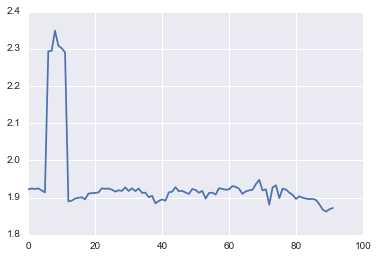

In [435]:
plt.plot([results[date].alpha for date in fdic_sdi_panel.minor_axis])

But this maximum likelihood estimator holds only for a <em>given</em> value of $x_{min}$...
<ul>
  <li>\cite{clauset2009power} suggest estimating $x_{min}$ from the data by choosing a value $\hat{x}_{min}$ that minimizes the "distance" between the empirical distribution of the observed data and the best-fit power law model above $\hat{x}_{min}$.</li>
</ul>

The procedure for choosing $x_{min}$ is basically a brute force search:
<ol>
  <li>Choose a set of candidate threshold parameters, $\Theta$ from the observed data.</li>
  <li>For each $x_{min}^{c} \in \Theta$ obtain an estimate of the scaling exponent $\hat{\alpha}^{c}$ using maximum likelihood and then calculates the Kolmogorov-Smirnov (KS) distance between the empirical distribution of the data above $x_{min}^c$ and the theoretical distribution of a power law with parameters $\hat{\alpha}^{c}$ and $x_{min}^c$.</li>
  <li>Optimal choice for the threshold parameter, $x_{min}$, is the $x_{min}^{*} \in \Theta$ which minimizes the KS distance between the observed data above $x_{min}^{*}$ and the theoretical power law distribution with scaling exponent, $\hat{\alpha}^{*}$.</li>
</ol>

<p>In order to get estimates of parameter uncertainty that accurately take into account the flexibility introduced by the joint estimation of $\alpha$ and $x_{min}$, standard errors and confidence intervals for the parameter estimates are estimated using a basic non-parametric bootstrap procedure.</p>

In [230]:
"""
Loop over the various measures of fdic_sdi_panelic_sdi_panelk size and fit a
power law model to each quarter of data. Parameter estimation results are
stored in a nested dictionary

"""
base_date = '2015-09-30'

parameter_estimation_results = {}

for item in fdic_sdi_panel.items:
    
    parameter_estimation_results[item] = {}
    normalized_size_measure = normalize_size_measure(item, base_date)
    
    for date in fdic_sdi_panel.minor_axis:
        data = normalized_size_measure[date].dropna()
        cleaned_data = data[data > 0].dropna()
        fit = powerlaw.Fit(cleaned_data, xmin=None)
        parameter_estimation_results[item][date] = fit

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

<h3>Don't forget to assess goodness of fit!</h3>

I would like to ask whether, given data on some measure of bank size, the power law model is a plausible model for the upper tail of the size distribution...

I test the plausibility of the power law model using the same simulation procedure detailed in <a href="http://arxiv.org/abs/0706.1062">Clauset et al (SIAM, 2009)</a>: 
<ol>
    <li>Fit the power law model using maximum likelihood procedure to find the optimal parameter estimates $\hat{\alpha}$, and $\hat{x}_{min}$.</li>
    <li>Extract the KS test statistic for the optimal fit: this is my ``observed'' test statistic.</li>
    <li>Generate a large number, say $B=2500$, synthetic data sets that mimic the empirical data below $\hat{x}_{min}$, but follow a true power law with scaling parameter $\hat{\alpha}$ in the tail.</li>
    <li>For each of the $i \in \ 1,\dots,B$ synthetic data sets: fit power law model to $i$-th synthetic data set and find the optimal parameters and the KS test statistic.</li>  
</ol>    
As the $p$-value for my goodness-of-fit test, I take the fraction of the $B$ KS statistics larger than the "observed" KS statistic. A large $p$-value (i.e., $>$ 0.10) indicates power law model is plausible; small $p$-values (i.e., $p$-values $\le$ 0.05) indicates power law can be rejected as plausible given the data.

<p>To provide some context,  a $p$-value of 0.05 indicates that there is roughly a 1 in 20 chance that I would observe data on bank sizes for a given year that agree as poorly (as measured by the KS test statistic) with the power law model as the data that I actually observe.<p>

<h3>Don't forget to test alternative hypotheses!</h3>

Not enough just to fit a power law distrubtion some data and write a paper...there might be distributions that are an even better fit!

I consider three common alternative distributions for heavy-tailed data...

<ul>
  <li>log-normal</li>
  <li>stretched-exponential (i.e., Weibull)</li>
  <li>truncated power law (i.e., power law with an exponential cut-off)</li>
</ul>

...and one thin-tailed alternative: the exponential distribution.

<p>I use a <a href="https://en.wikipedia.org/wiki/Vuong%27s_closeness_test">Vuong likelihood ratio test</a> implemented in two steps to test off the power law model against various alternatives...</p>
<ol>
  <li> Consider the two-sided null hypothesis that each of the power law and the alternative are equally far from the "true distribution" against a general alternative.  If I reject this two-sided null hypothesis, then I conclude that one of the power law or the alternative is preferred (given the data).</li>
  <li> Second I consider a one-sided null hypothesis of a power law against the alternative distribution directly.</li>
</ol>
  
<p>A rejection of the two-sided null hypothesis, followed by a failure to reject the one-sided null hypothesis of a power law implies the data are sufficient to distinguish between the power law and the considered alternative, and the the power law model if preferred.</p>

A major advantage of using the Vuong likelihood ratio test over the classic likelihood ratio test is that the former will alert the researcher to the possibility that the data are not sufficient to favor either the power law or the alternative model.

<h1>Results</h1>

<h2>Parameter estimates</h2>

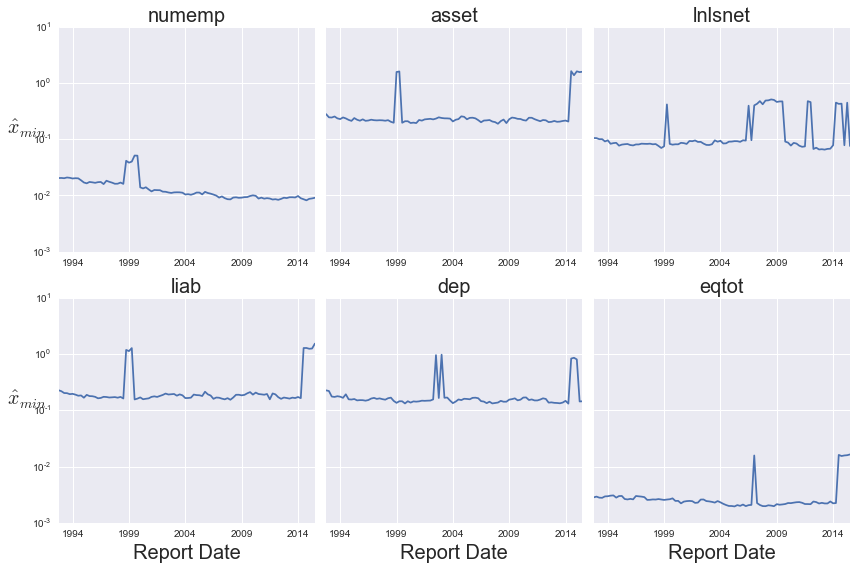

In [443]:
dates = fdic_sdi_panel.minor_axis

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
for i, size_measure in enumerate(fdic_sdi_panel.items):
    ax = axes.flatten()[i]
    results = parameter_estimation_results[size_measure]
    ns = pd.Series({date: results[date].n for date in dates})
    xmins = pd.Series({date: results[date].xmin for date in dates})
    #sigmas = alphas / np.sqrt(ns)
    xmins.plot(ax=ax, label=size_measure)
    
    # plot classic MLE confidence intervals...
    #lower = alphas - 1.96 * sigmas
    #upper = alphas + 1.96 * sigmas
    #ax.fill_between(alphas.index, lower, upper, color='grey', alpha=0.5)
    #ax.axhline(2.0, color='k', linestyle='dashed', label="Zipf's Law")
    
    if i in [0, 3]:
        ax.set_ylabel(r'$\hat{x}_{min}$', rotation=0, fontsize=20)
    if i in [3, 4, 5]:
        ax.set_xlabel("Report Date", fontsize=20)

    ax.set_yscale('log')
    ax.set_title(size_measure, fontsize=20)


fig.tight_layout()
#fig.suptitle("Estimated Scaling Exponents", x=0.5, y=1.05, fontsize=25)
#fig.savefig('./assets/img/estimated-scaling-exponents.jpg', bbox_inches='tight')

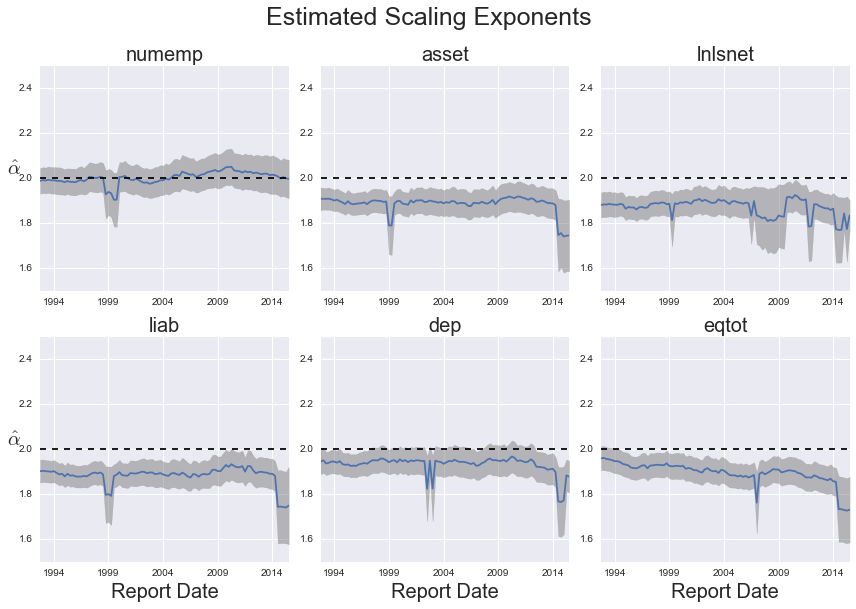

In [438]:
dates = fdic_sdi_panel.minor_axis

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, size_measure in enumerate(fdic_sdi_panel.items):
    ax = axes.flatten()[i]
    results = parameter_estimation_results[size_measure]
    ns = pd.Series({date: results[date].n for date in dates})
    alphas = pd.Series({date: results[date].alpha for date in dates})
    sigmas = alphas / np.sqrt(ns)
    alphas.plot(ax=ax, label=size_measure)
    
    # plot classic MLE confidence intervals...
    lower = alphas - 1.96 * sigmas
    upper = alphas + 1.96 * sigmas
    ax.fill_between(alphas.index, lower, upper, color='grey', alpha=0.5)
    ax.axhline(2.0, color='k', linestyle='dashed', label="Zipf's Law")
    
    if i in [0, 3]:
        ax.set_ylabel(r'$\hat{\alpha}$', rotation=0, fontsize=20)
    if i in [3, 4, 5]:
        ax.set_xlabel("Report Date", fontsize=20)

    ax.set_ylim(1.5, 2.5)
    ax.set_title(size_measure, fontsize=20)


fig.tight_layout()
fig.suptitle("Estimated Scaling Exponents", x=0.5, y=1.05, fontsize=25)
fig.savefig('./assets/img/estimated-scaling-exponents.jpg', bbox_inches='tight')

<img src="./assets/img/estimated-scaling-exponents.jpg" alt="Estimated scaling exponents">

<h2>Summary</h2>
<ul>
  <li>Tail of the size distribution is so heavy that the mean of the best-fitting power law model is undefined! There is no such thing as an "average" sized bank in the U.S.!</li>
  <li>Only measure of bank size broadly consistent with Zipf's Law is number of employees.</li>
  <li>When either `asset`, `lnlsnet`, or `liab` are used as the measure of bank size $\hat{\alpha}$ is roughly constant across time.</li>
  <li>When `dep` are used as the measure of bank size the $\hat{\alpha}$ is slightly larger (though still significantly less than $\alpha=2$).</li>
  <li> Only measure of size for which there is a clear trend in $\hat{\alpha}$ is `eqtot`. The negative trend indicates that U.S banking sector equity holdings are becoming increasingly concentrated over time.
</ul>

<h2>Goodness of fit tests</h2>

<h2>Insert new results here!</h2>

<h2>Old results from my PhD chapter</h2>

</blockquote>The results of these goodness-of-fit tests are not supportive of the power law distribution as a model for the upper tail of the bank size distribution: in the majority of cases the observed KS distance between the best-fit power law model and the data is larger than \text{any} of the simulated KS distances.</blockquote>

<h2>Likelihood Ratio tests</h2>

In [338]:
def likelihood_ratio_results(fig, axes, alternative):
    """Plot time series for likelihood ratio test statistics and associated p-values."""
    
    for i, size_measure in enumerate(fdic_sdi_panel.items):
        ax0 = axes.flatten()[i]
        ax1 = ax0.twinx()

        dates = fdic_sdi_panel.minor_axis
        results = parameter_estimation_results[size_measure]
        
        # extract the test statistics and p-values
        Rs = {}
        ps = {}
        for date in dates:
            Rs[date], ps[date] = results[date].distribution_compare("power_law", alternative)

        llr_test_statistics = pd.Series(Rs)
        llr_test_statistics.plot(ax=ax0)
        ax0.axhline(0.0, color='k', linestyle='dashed')

        llr_test_pvalues = pd.Series(ps)
        llr_test_pvalues.plot(ax=ax1, color='r')

        # format the axes...
        if i in [0, 3]:
            ax0.set_ylabel(r'$R$', rotation=0, fontsize=20)
        if i in [2, 5]:
            ax1.set_ylabel('p-value', fontsize=20)
        if i in [3, 4, 5]:
            ax0.set_xlabel("Report Date", fontsize=20)
        if i in [0, 1, 3, 4]:
            ax1.tick_params(axis='y', right='off', labelright='off')

        ax1.set_yscale('log')
        ax0.set_title(size_measure, fontsize=20)

    fig.tight_layout()


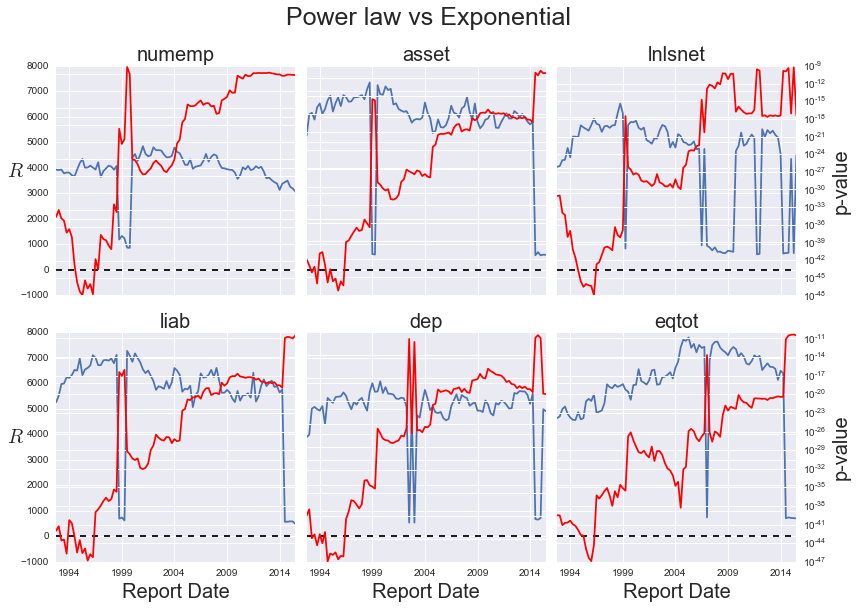

In [339]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "exponential")
fig.suptitle("Power law vs Exponential", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-exponential-llr-results.jpg', bbox_inches='tight')

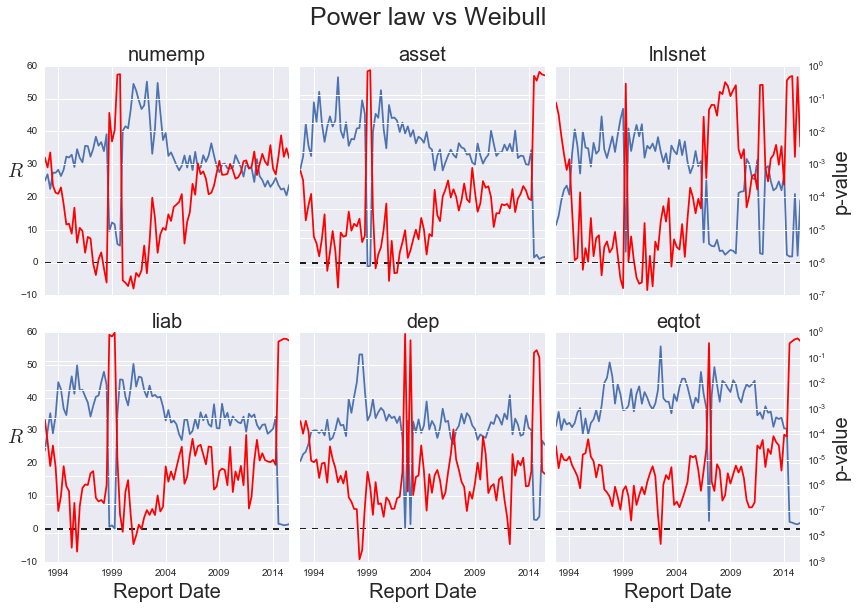

In [340]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "stretched_exponential")
fig.suptitle("Power law vs Weibull", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-weibull-llr-results.jpg', bbox_inches='tight')

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming n

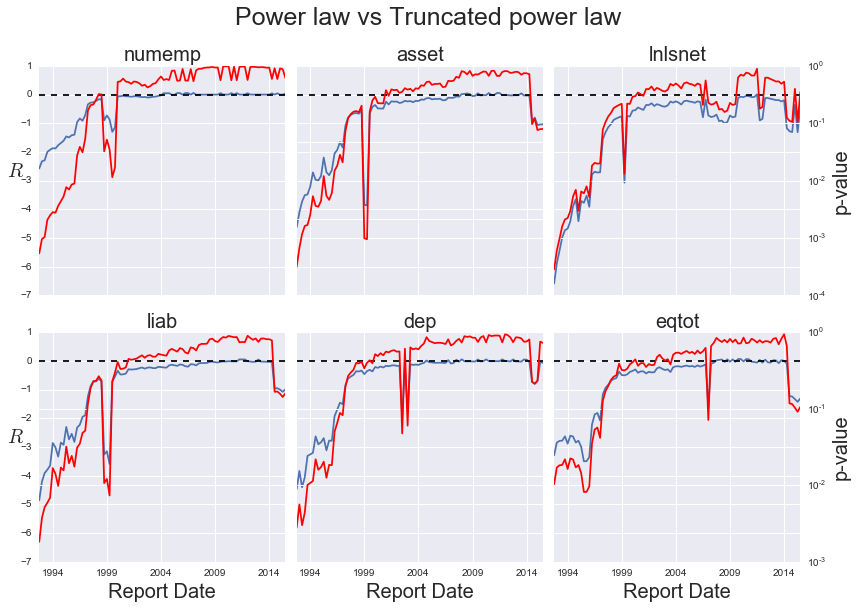

In [341]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey=True)
likelihood_ratio_results(fig, axes, "truncated_power_law")
fig.suptitle("Power law vs Truncated power law", x=0.5, y=1.05, fontsize=25)
plt.savefig('./assets/img/power-law-vs-truncated-power-law-llr-results.jpg', bbox_inches='tight')

<img src="./assets/img/power-law-vs-exponential-llr-results.jpg" alt="Power law vs exponential">

<img src="./assets/img/power-law-vs-weibull-llr-results.jpg" alt="Power law vs weibull">

<img src="./assets/img/power-law-vs-truncated-power-law-llr-results.jpg" alt="Power law vs truncated power law">

<h3>Summary</h3>
<ul>
  <li>Power law model clearly preferred to both the exponential distribution and the stretched exponential (Weibull) distributions (not at all surprising...but a nice sanity check).</li>
  <li>Given the data it is generally not possible to distinguish between the power law and the log-normal alternative.</li>
  <li>Finally, while the power law distribution with an exponential cut-off is preferred over the pure power law model in the early 1990's, this distribution becomes less plausible over time.</li>
</ul>  

<h2> Conclusions </h2>

<p>Statistically significant departures from Zipf's Law for most measures of bank size in most years...</p>
<ul>
  <li>$\hat{\alpha} \approx 1.9 < 2$ indicates that U.S. the banking sector is too concentrated to be consistent with the predictions of Zipf's Law.</li>
  <li>Goodness-of-fit tests document statistically significant deviations from a pure power law model, it is not clear whether or not the observed deviations are economicially significant.</li>
  <li>Likelihood ratio testing results indicate that the power law model out-performs other distributions commonly used to model heavy-tailed data.</li>
</ul>

<strong>Conclusion:</strong> Power law distribution with $\hat{\alpha} \approx 1.9$ is a pretty good model for the upper tail of the size distribution of U.S. banks.

<strong>Conclusion:</strong> Estimates of the scaling exponent are fairly stable over time for most size measures.

<strong>Conclusion:</strong> U.S. banking sector exhibits higher levels of concentration than U.S. firms. 

<h3>Implications for empirical and theoretical business cycle research?</h3> 

<a href="http://pages.stern.nyu.edu/~xgabaix/papers/granular.pdf">Gabaix (Econometric, 2011)</a> posits that, if upper tail of the firm size distribution is sufficiently heavy, significant variation in aggregate macroeconomic time series could be explained by idiosyncratic shocks to individual firms.

Presumbably there is a "granularity hypothesis" for the banking sector where idiosyncratic shocks to systematically important financial institutions (SIFIs) could also explain some variation in aggregate macroeconomic time series.

<h2> Thanks! </h2>